In [2]:
import random
from functools import partial
import matplotlib
import matplotlib.image as mpimg
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from google.colab import drive
!pip install segmentation_models_pytorch
drive.mount('/content/gdrive')
import seaborn as sns
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, UnetPlusPlus, DeepLabV3, PSPNet
import segmentation_models_pytorch
!pip install torchmetrics
from torchmetrics.functional import f1_score

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0e983e92c7b0887fc5468d00365412e7e92254db9a3fc373fe37385f87855343
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=967fd7603e85569bcd2e1927a0161e50bf51585f827244468a95abbf63e352bf
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [3]:
###
###
# Paths
root_dir = "/content/gdrive/MyDrive/ML/data/original/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth"
test_image_dir = "data/test_set_images_gradient/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
###
###
# Hyper parameters
PADDING = 0
EPOCH = 100
BATCH_SIZE = 10
NR_IMAGES = 100
IMAGE_SIZE = 256

In [24]:
class PreloadedDataset(Dataset):
    def __init__(self, images, ground_truth):
        self.images = images
        self.ground_truth = ground_truth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        ground_truth = self.ground_truth[idx]
        return image, ground_truth


def split(dataset, tr,val):
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [tr, val])
    return train_dataset, val_dataset

def get_dataloaders(train_dataset, val_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader

def load_npy(npy_file_path):
  array = np.load(npy_file_path)
  return array

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def get_image_name(image_dir):
    file_name = os.path.basename(image_dir)
    return file_name

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]

    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

def predict_patches(prediction, patch_threshold):
    patches = img_crop(prediction, 16, 16)
    iter = int(np.sqrt(len(patches)))
    results = np.zeros((iter, iter))
    c = 0
    for j in range(iter):
      for i in range(iter):
        if patches[c].mean() > patch_threshold:
          results[i, j] = 1
        c = c + 1
    return results

def masks_to_submission(submission_filename, results):
    """Converts images into a submission file"""
    img_number = 0
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for res in results:
            img_number = img_number + 1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(res, img_number))

def mask_to_submission_strings(result, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = result
    patch_size = 16
    for j in range(0, im.shape[1]):
        for i in range(0, im.shape[0]):
            label = result[i, j]

            yield("{:03d}_{}_{},{}".format(img_number, j*16, i*16, int(label)))

def write_predictions_to_file(predictions, labels, filename):
    max_labels = np.argmax(labels, 1)
    max_predictions = np.argmax(predictions, 1)
    file = open(filename, "w")
    n = predictions.shape[0]
    for i in range(0, n):
        file.write(max_labels(i) + " " + max_predictions(i))
    file.close()

def compute_f1(res, ans):
    """
    Precision: tp/(tp+fp)
    Recall: tp/(tp+fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    """

    tp = torch.sum((res == 1) & (ans == 1))
    fp = torch.sum((res == 1) & (ans != 1))
    fn = torch.sum((res != 1) & (ans == 1))

    precision = tp / (tp + fp) if (tp + fp) != 0 else torch.tensor(0.0)
    recall = tp / (tp + fn) if (tp + fn) != 0 else torch.tensor(0.0)
    if precision + recall == 0:
        return torch.tensor(0.0)
    else:
        return 2 * (precision * recall) / (precision + recall)


def get_threshold(predictions,labels):
    f1_max = 0
    th = 0

    for t in range(0,100):
        t = t/100
        th_pred = predictions.clone()
        patches = predict_patches(th_pred, t)
        f1 = f1_score(torch.tensor(patches), torch.tensor(labels), task='binary')

        if f1>f1_max:
            f1_max = f1
            th = t
    return th

def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()

    # Use tensors for histories
    total_loss = torch.tensor(0.0, device=device)
    total_samples = 0
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)
    batch_iter = 0
    for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):

        # Prepare batch
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_data)

        # Compute loss
        loss = criterion(output, batch_labels)
        total_loss = total_loss + loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy and F1 per batch
        predictions = (output > 0.3).int()  # Hardcoded threshold
        batch_correct = (predictions == batch_labels).sum()

        batch_accuracy = batch_correct / (batch_labels.shape[0] * batch_labels.shape[1] * batch_labels.shape[2] * batch_labels.shape[3])
        total_accuracy = total_accuracy + batch_accuracy

        total_f1 = total_f1 + f1_score(predictions, batch_labels, task='binary')



        batch_iter = batch_iter + 1




    # Compute averages for the epoch
    epoch_loss = total_loss / batch_iter
    epoch_accuracy = total_accuracy / batch_iter
    epoch_f1 = total_f1 / batch_iter

    # Log the learning rate history
    lr_value = scheduler.get_last_lr()[0]

    print(
        f"Epoch Summary: {epoch} "
        f"Epoch Loss={epoch_loss.item():.3e} "
        f"Accuracy={epoch_accuracy.item():.3f} "
        f"F1={epoch_f1.item():.3e} "
        f"LR={lr_value:.3e}"
    )

    # Return metrics as tensors
    return epoch_loss, epoch_accuracy, lr_value, epoch_f1



@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm, etc.)

    # Initialize tensors for aggregating metrics
    total_loss = torch.tensor(0.0, device=device)
    total_accuracy = torch.tensor(0.0, device=device)
    total_f1 = torch.tensor(0.0, device=device)


    batch_iter = 0
    for data, target in val_loader:
        # Prepare batch

        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)



        # Compute loss
        batch_loss = criterion(output, target)
        total_loss = total_loss +  batch_loss

        # Compute predictions
        probabilities = F.sigmoid(output)
        predictions = (probabilities > 0.3).int()  # Hardcoded threshold
        total_f1 = total_f1 + compute_f1(predictions, target)

        # F1 and accuracy
        batch_correct = (predictions == target).sum()
        batch_accuracy = batch_correct / (target.shape[0] * target.shape[1] * target.shape[2] * target.shape[3])

        total_accuracy = total_accuracy + batch_accuracy




        batch_iter = batch_iter + 1

    # Compute averages
    avg_loss = total_loss / batch_iter
    avg_accuracy = total_accuracy / batch_iter
    avg_f1 = total_f1 / batch_iter

    # Print validation summary
    print(
        f"Validation Set: Average Loss: {avg_loss.item():.4f}, "
        f"Accuracy: {avg_accuracy.item() * 100:.2f}%, "
        f"F1: {avg_f1.item():.4f}, "
    )

    # Return metrics as tensors
    return avg_loss, avg_f1, avg_accuracy * 100


def run_training(
    model,
    num_epochs,
    optimizer_kwargs,
    data_kwargs,
    device="cuda",

):
    # ===== Data Loading =====
    train_loader, val_loader = get_dataloaders(**data_kwargs)

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)
    # model.apply(init_weights)
    #optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    optimizer = torch.optim.SGD(model.parameters(), **optimizer_kwargs)
    criterion = segmentation_models_pytorch.losses.DiceLoss("binary")
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []
    train_f1_history = []
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        train_loss, train_acc, lrs, f1_hist = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        lr_history.append(lrs)

        val_loss, f1, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_f1_history.append(f1)
        val_acc_history.append(val_acc)
        train_f1_history.append(f1_hist)
        scheduler.step()

    return train_loss_history, train_acc_history, val_loss_history, val_f1_history, val_acc_history, train_f1_history


In [8]:
###
###
# Loading data set


imgs = []
gt_imgs = []
image_files = sorted(os.listdir(image_dir))[:NR_IMAGES]
gt_files = sorted(os.listdir(gt_dir))[:NR_IMAGES]
org_len = len(gt_files)
img_nr = 0

for image_file in image_files:
    # Removing from image name (extended)
    image_name = os.path.splitext(image_file)[0]#[:-10]
    matching_gt_file = None

    gt_match_index = 0
    for gt_file in gt_files:

        gt_name = os.path.splitext(gt_file)[0]

        if gt_name[-4:] == '.png':
            gt_name = gt_name[:-4]
        if gt_name == image_name:
            matching_gt_file = gt_file
            img_nr = img_nr + 1
            print(f'{img_nr} / {org_len} loaded')
            break

    if matching_gt_file:
        image_path = os.path.join(image_dir, image_file)
        gt_path = os.path.join(gt_dir, matching_gt_file)

        image = load_image(image_path)
        gt_image = load_image(gt_path)
        imgs.append(image[:256, :256,:])
        imgs.append(image[144:, :256,:])
        imgs.append(image[:256, 144:,:])
        imgs.append(image[144:, 144:,:])

        gt_imgs.append(gt_image[:256, :256])
        gt_imgs.append(gt_image[144:, :256])
        gt_imgs.append(gt_image[:256, 144:])
        gt_imgs.append(gt_image[144:, 144:])


1 / 100 loaded
2 / 100 loaded
3 / 100 loaded
4 / 100 loaded
5 / 100 loaded
6 / 100 loaded
7 / 100 loaded
8 / 100 loaded
9 / 100 loaded
10 / 100 loaded
11 / 100 loaded
12 / 100 loaded
13 / 100 loaded
14 / 100 loaded
15 / 100 loaded
16 / 100 loaded
17 / 100 loaded
18 / 100 loaded
19 / 100 loaded
20 / 100 loaded
21 / 100 loaded
22 / 100 loaded
23 / 100 loaded
24 / 100 loaded
25 / 100 loaded
26 / 100 loaded
27 / 100 loaded
28 / 100 loaded
29 / 100 loaded
30 / 100 loaded
31 / 100 loaded
32 / 100 loaded
33 / 100 loaded
34 / 100 loaded
35 / 100 loaded
36 / 100 loaded
37 / 100 loaded
38 / 100 loaded
39 / 100 loaded
40 / 100 loaded
41 / 100 loaded
42 / 100 loaded
43 / 100 loaded
44 / 100 loaded
45 / 100 loaded
46 / 100 loaded
47 / 100 loaded
48 / 100 loaded
49 / 100 loaded
50 / 100 loaded
51 / 100 loaded
52 / 100 loaded
53 / 100 loaded
54 / 100 loaded
55 / 100 loaded
56 / 100 loaded
57 / 100 loaded
58 / 100 loaded
59 / 100 loaded
60 / 100 loaded
61 / 100 loaded
62 / 100 loaded
63 / 100 loaded
6

In [14]:
# Converting to float
imgs = np.array([sub_arr.astype(np.float32) for sub_arr in imgs])
gt_imgs = np.array([sub_arr.astype(np.float32) for sub_arr in gt_imgs])

# Making sure gt is binary, road or no road
gt_imgs[gt_imgs > 0] = 1

AttributeError: 'Tensor' object has no attribute 'astype'

In [10]:
# Converting to tensors
gt_imgs = torch.tensor(gt_imgs)
imgs = torch.tensor(imgs)

In [11]:
imgs.shape
imgs = imgs.permute(0, 3, 1, 2)

In [12]:
gt_imgs.shape

torch.Size([400, 256, 256])

In [13]:
gt_imgs = gt_imgs.reshape(400, 1, 256, 256)

In [ ]:
# Converting gt to 2-channel data
# gt_imgs_2_channel = []
# for image in gt_imgs:

#   two_im = torch.zeros((IMAGE_SIZE, IMAGE_SIZE,2), dtype=torch.float32)

#   mask0 = (image == 0).float()
#   mask1 = (image == 1).float()
#   two_im = torch.stack((mask0, mask1), dim=-1)
#   gt_imgs_2_channel.append(two_im)

In [ ]:
# To tensor and permutate
# gt_imgs_2_channel = torch.tensor(np.array(gt_imgs_2_channel))
# gt_imgs_2_channel = gt_imgs_2_channel.permute(0,3,1,2)
# imgs = imgs.permute(0,3,1,2)

In [15]:
# Loading train_loader and val_loader
dataset = PreloadedDataset(images = imgs, ground_truth = gt_imgs)
train_dataset, val_dataset = split(dataset, 0.8, 0.2)

In [25]:
num_epochs = EPOCH

learning_rates = [1e-4]
weight_decays = [1e-4]


data_kwargs = dict(
    train_dataset=train_dataset,
    val_dataset = val_dataset,
    batch_size=BATCH_SIZE
)

# For Hyperparameter fitting
combinations = []
train_losses = []
val_losses = []
train_f1 = []
val_f1 = []

best_loss = 20
for l in learning_rates:
  for wd in weight_decays:
      model = model = Unet(
      encoder_name="resnet50",        # Choose encoder
      encoder_weights="imagenet",    # Use pre-trained ImageNet weights
      classes=1,                     # Number of output classes
      activation=None               # No activation, as it's handled in loss/metrics
)
      optimizer_kwargs = dict(
      lr=l,
      weight_decay=wd,
      )
      train_loss, train_acc_history, val_loss_history, val_f1_history, val_acc_history, train_f1_history = run_training(
          model=model,
          num_epochs=num_epochs,
          optimizer_kwargs=optimizer_kwargs,
          data_kwargs=data_kwargs,
          device=device,
          )
      combination = 'learning_rate_' +  str(l) + '_weight_decay_' + str(wd)
      combinations.append(combination)

      train_f1.append(train_f1_history)
      val_f1.append(val_f1_history)
      train_losses.append(train_loss)
      val_losses.append(val_loss_history)

      if train_loss[-1] < best_loss:
        best_loss = train_loss[-1]
        best_pair = (l,wd)



model.save_pretrained("U_NET++_1_base_case_100_im.pth")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


20


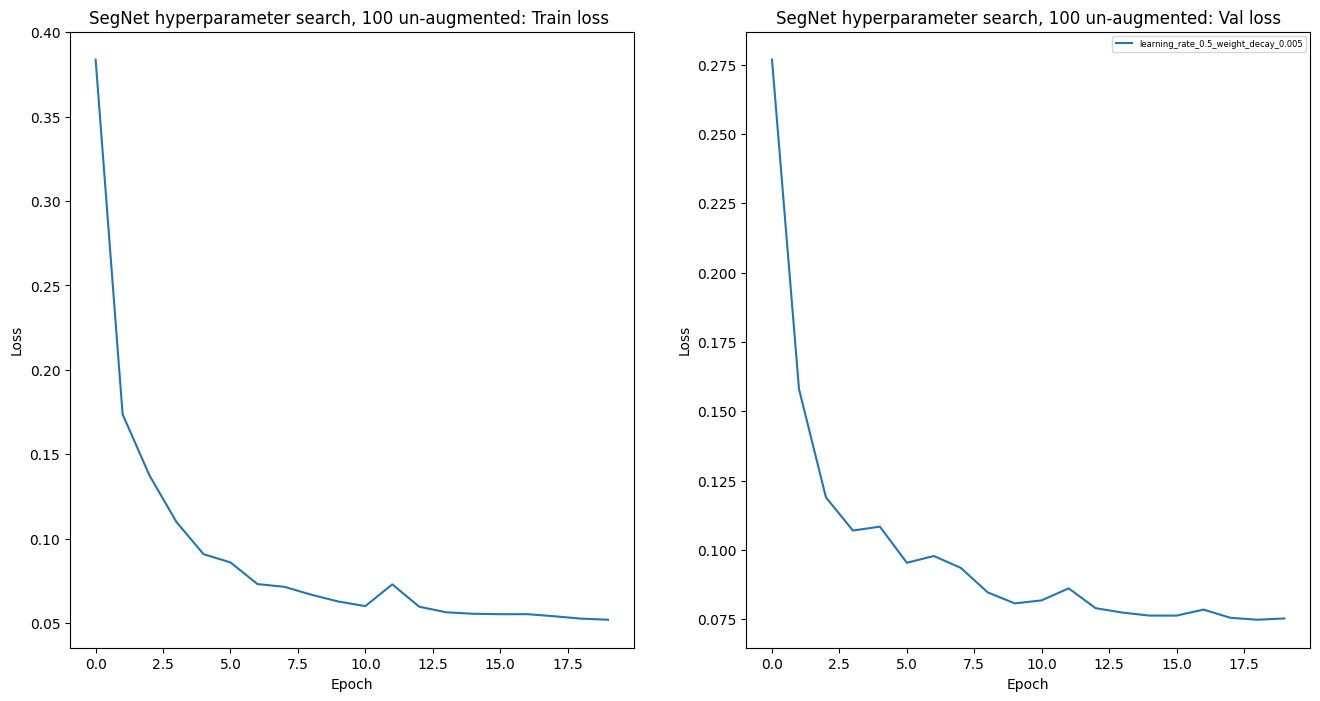

In [17]:
n_colors = 9
colors = plt.cm.tab20c(np.linspace(0, 1, n_colors))

train_losses = [[loss.cpu().detach().numpy() for loss in loss_param] for loss_param in train_losses]
val_losses = [[loss.cpu().detach().numpy() for loss in loss_param] for loss_param in val_losses]



fig, axes = plt.subplots(1, 2, figsize=(16, 8))
print(len(train_losses[0]))
iterations = len(learning_rates) * len(weight_decays)
for i in range(iterations):
    train_losses[i] = [entry for entry in train_losses[i]]
    axes[0].plot(train_losses[i], label=combinations[i])

axes[0].set_title('SegNet hyperparameter search, 100 un-augmented: Train loss ')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

plt.legend(fontsize=6)


iterations = len(learning_rates) * len(weight_decays)
for i in range(iterations):
    axes[1].plot(val_losses[i], label=combinations[i])

axes[1].set_title('SegNet hyperparameter search, 100 un-augmented: Val loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

plt.legend(fontsize=6)

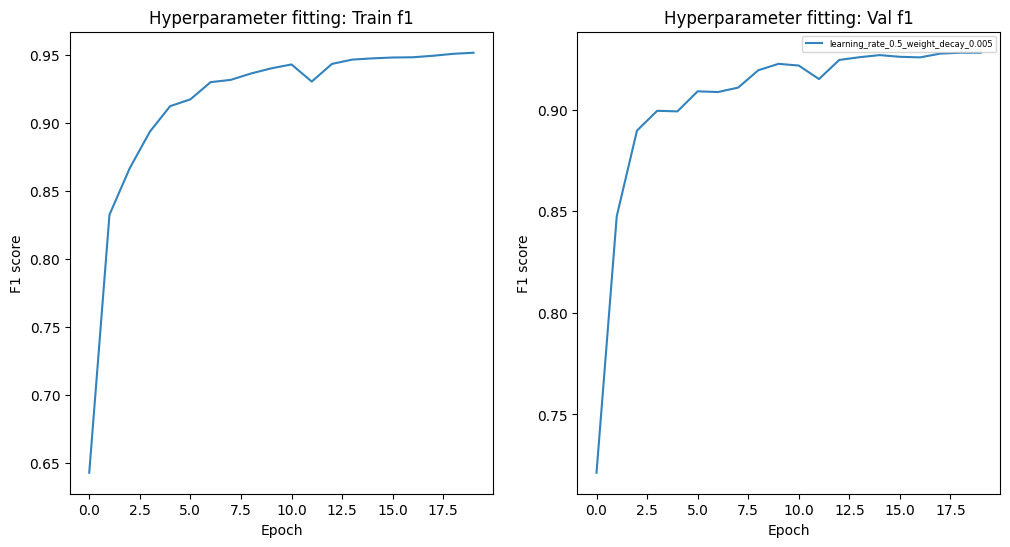

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
iterations = len(learning_rates) * len(weight_decays)

train_f1 = [[f1.cpu().detach().numpy() for f1 in param] for param in train_f1]
val_f1 = [[f1.cpu().detach().numpy() for f1 in param] for param in val_f1]

for i in range(iterations):
    axes[0].plot(train_f1[i], label=combinations[i], color = colors[i])

axes[0].set_title('Hyperparameter fitting: Train f1')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('F1 score')

plt.legend(fontsize=6)


iterations = len(learning_rates) * len(weight_decays)

for i in range(iterations):
    axes[1].plot(val_f1[i], label=combinations[i], color = colors[i])

axes[1].set_title('Hyperparameter fitting: Val f1')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 score')

plt.legend(fontsize=6)

In [21]:
!mv U_NET++_1_base_case_100_im.pth/_1_base_case_100_im.pth /content/gdrive/MyDrive/ML/models

mv: cannot stat 'U_NET++_1_base_case_100_im.pth/_1_base_case_100_im.pth': No such file or directory
